# Data Preprocess

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier

from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

import re
import datetime

2023-11-27 01:20:21.528223: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 01:20:21.530032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 01:20:21.571469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 01:20:21.572128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 01:20:22.329133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Read Data

In [2]:
links = pd.read_csv("ml-latest-small/links.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

Prepare dataset

In [3]:
# Merge tags and ratings
tags_ratings = pd.merge(tags, ratings, on=['userId','movieId'], how='outer', suffixes=('_tags', ' '))
# # Drop columns that contain _rating
tags_ratings = tags_ratings.drop(columns=['timestamp_tags'])

# Merge tags_ratings and movies
data = pd.merge(tags_ratings, movies, on=['movieId'], how='outer', suffixes=(' ', '_movie'))
# Rename timestamp column as timestamp
data = data.rename(columns={'timestamp ': 'timestamp'})
# Change column order
data = data[["movieId","userId", "title", "rating","genres" ,"tag","timestamp"]]
# Drop rows with NaN timestamp
data = data.dropna(subset=["timestamp"])
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['timestamp'].astype('datetime64[ns]')

0        2015-10-24 22:29:40
1        2015-10-24 22:29:40
2        2015-10-24 22:29:40
3        2018-06-14 02:59:36
4        2018-06-14 02:59:36
                 ...        
102879   2016-11-19 11:55:49
102880   2016-11-19 11:43:18
102881   2017-05-03 23:53:14
102882   2017-05-04 00:59:49
102883   2017-05-04 01:22:35
Name: timestamp, Length: 102677, dtype: datetime64[ns]

In [4]:
tagratings = pd.pivot_table(data, values=['rating'], columns=['tag'], aggfunc='mean')
tagratings

tag,"""artsy""",06 Oscar Nominated Best Movie - Animation,1900s,1920s,1950s,1960s,1970s,1980s,1990s,2001-like,...,women,wonderwoman,workplace,writing,wrongful imprisonment,wry,younger men,zither,zoe kazan,zombies
rating,3.5,4.166667,3.5,4.0,4.0,3.0,3.833333,4.25,5.0,4.5,...,4.0,4.0,4.0,3.833333,5.0,5.0,4.5,4.0,4.0,3.916667


In [5]:
data['rating'] = data['rating'].apply(lambda x: 1 if x > 4 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x))
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
data['tag'] = data['tag'].str.lower()

# Model Development

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tag'])
sequences = tokenizer.texts_to_sequences(data['tag'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

Found 1731 unique tokens.


In [7]:
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = data['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()

words = vectorizer.get_feature_names_out()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(wordvec,columns=words)

number of words in plot summary:  1658


In [8]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(words), 100))
for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


## K-Means

In [9]:
reduced_data = PCA(n_components=2).fit_transform(pdembedding.T)
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

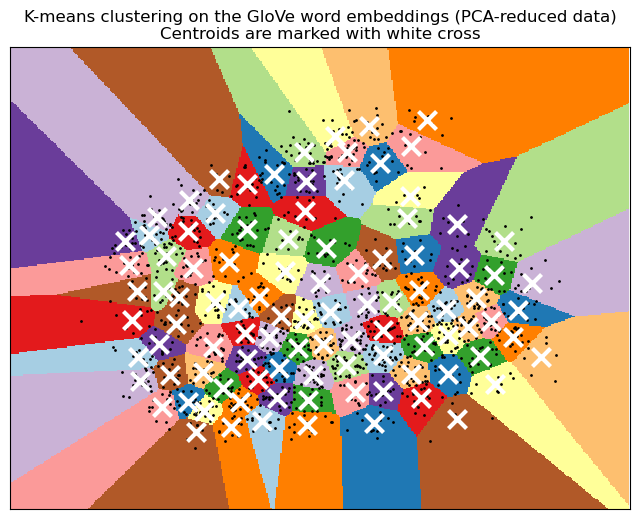

In [10]:
plt.figure(figsize=(8, 6))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

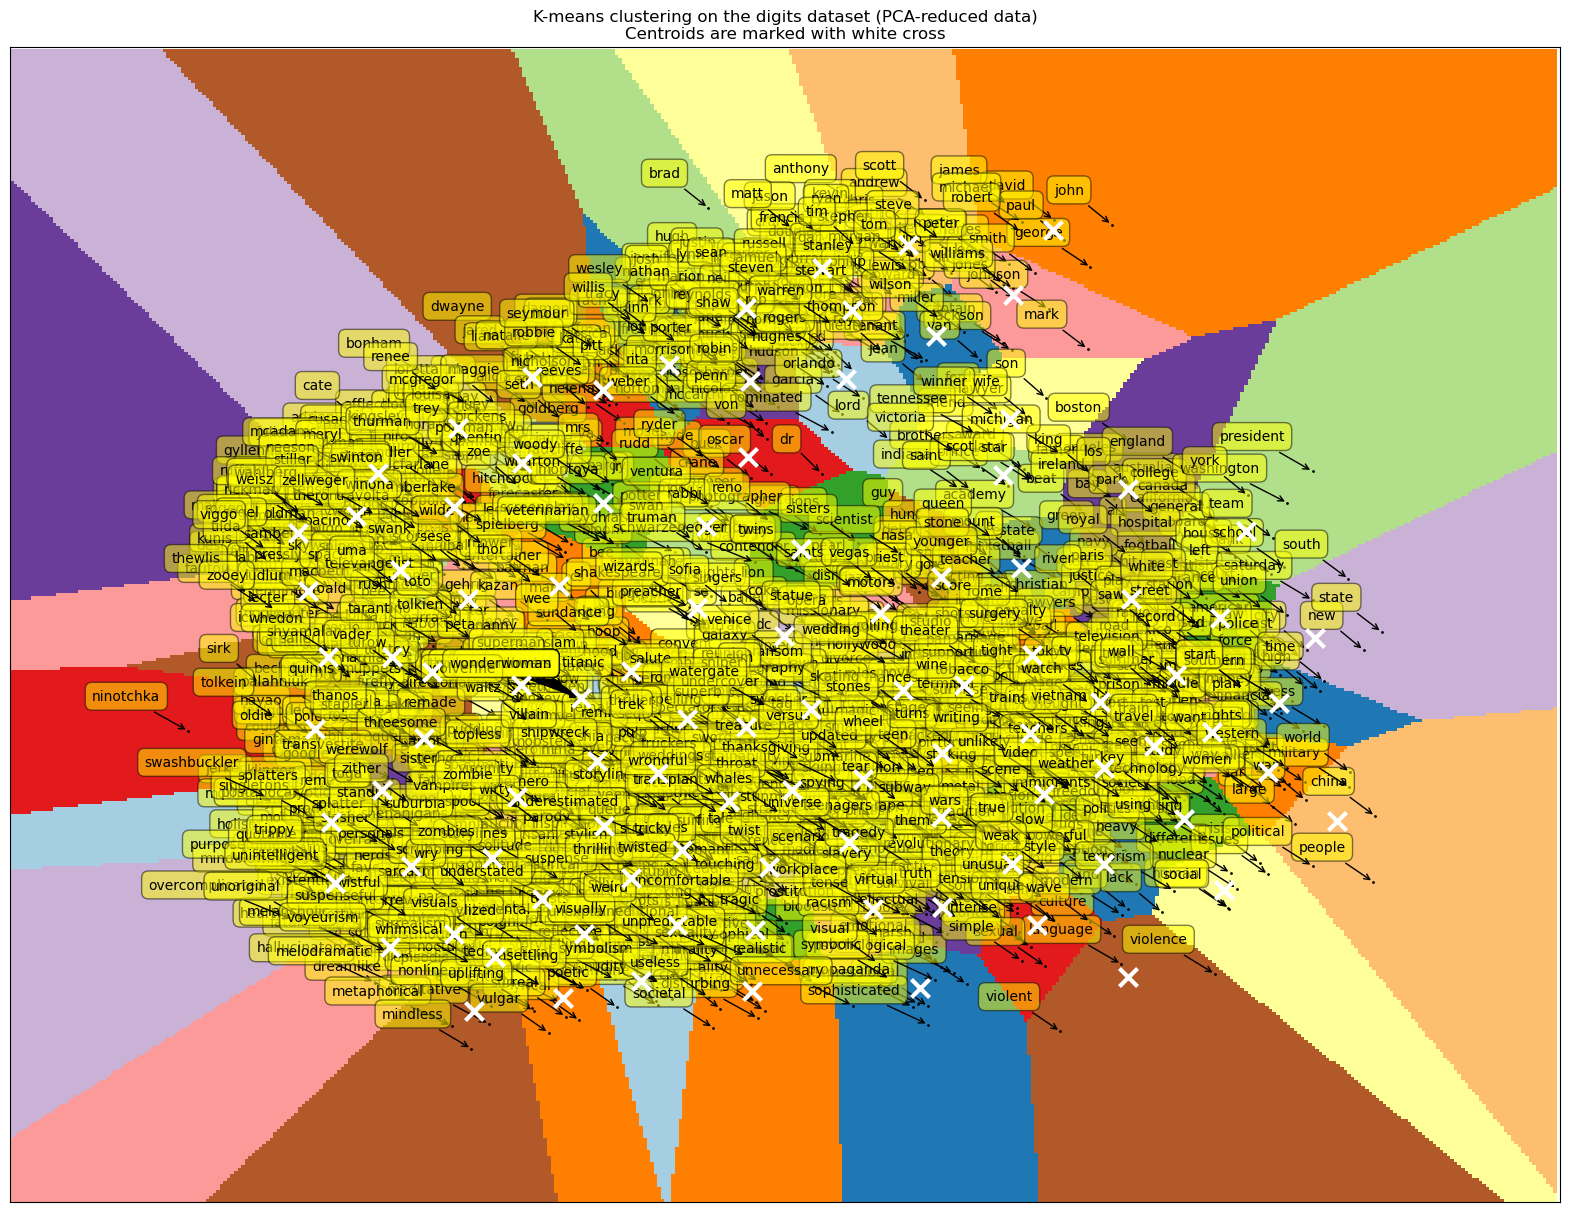

In [11]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Deep Learning

Prepare data for Deep Learning

In [12]:
# For deep learning with LSTM, we will only use word sequences
dpdata = pd.concat([data, pdseq], axis=1)

dpdata = dpdata.drop(['tag'], axis=1)
dpdata = dpdata.drop(['userId'], axis=1)
dpdata = dpdata.drop(['movieId'], axis=1)

Prepare data for Clustering

In [13]:
#Cluster word embeddings data 
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pdembedding.T)
#Get cluster labels
clusters = kmeans.labels_

#Add columns to data for each cluster
for i in range(max(clusters)+1):
 data[i] = 0

#If word is in data row, label the associated cluster accordingly with 1
for i in range(len(pdwordvec.columns)):
    column = pdwordvec.columns[i]
    index = pdwordvec[column].loc[pdwordvec[column] > 0, ].index
    for ii in range(len(index)):
        data.loc[index[ii],clusters[i]] = 1

/tmp/ipykernel_80477/1419938428.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i] = 0
/tmp/ipykernel_80477/1419938428.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i] = 0
/tmp/ipykernel_80477/1419938428.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i] = 0
/tmp/ipykerne

In [14]:
#Drop tag as we will use vectorized words
data = data.drop(['tag'], axis=1)

#Add genres
#Split genre column
genresplit = movies.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
#Reset index of genresplit
genresplit = genresplit.reset_index()

#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genresplit, prefix='genre', columns=['genre']).groupby(level=0).sum()
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)
#Joın data by movieId
genres['movieId'] = genres.index
data = pd.merge(data, genres, on='movieId', how='left')

#Assign variables as categorical using one hot encoding
useridencoding = pd.get_dummies(data['userId'], prefix='userid')
data = data.drop(['userId'], axis=1)
data = pd.concat([data, useridencoding], axis=1)

movieidencoding = pd.get_dummies(data['movieId'], prefix='movieid')
data = data.drop(['movieId'], axis=1)
data = pd.concat([data, movieidencoding], axis=1)

In [15]:
data = data.fillna(np.nan)

## ML Classification Models

In [16]:
train = data[(data['timestamp'] < '2017-05-01') ]
test = data[(data['timestamp'] >= '2017-05-01') ]

print("len test data set:", len(test))
print("len training data set:",len(train))

len test data set: 13502
len training data set: 89175


In [17]:
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

In [18]:
baselineaccuracy = float(y_test.value_counts().max())/y_test.value_counts().sum()
print("Accuracy of the baseline model is: ", np.round(baselineaccuracy,2))

Accuracy of the baseline model is:  0.77


In [24]:
from sklearn.impute import SimpleImputer

x_train_numeric = x_train.select_dtypes(include=[np.number])
x_train_numeric.columns = x_train_numeric.columns.astype(str)

# Convert feature names to string
x_train_numeric.columns = x_train_numeric.columns.astype(str)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
x_train_numeric_imputed = imputer.fit_transform(x_train_numeric)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
x_train_numeric_imputed = imputer.fit_transform(x_train_numeric)

logreg = LogReg(C=1, class_weight='balanced')
logreg.fit(x_train_numeric_imputed, y_train)

x_test_numeric = x_test.select_dtypes(include=[np.number])

# Impute missing values in test data with mean
x_test_numeric_imputed = imputer.transform(x_test_numeric)

y_predlog = logreg.predict_proba(x_test_numeric_imputed)
R2_log = logreg.score(x_test_numeric_imputed, y_test)

R2_log = logreg.score(x_test_numeric, y_test)
print("Accuracy of the test set for log. reg. is: ", np.round(R2_log, 2))

/home/mustafa/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [25]:
c = [0.0000001,0.00001,0.0001,0.01, 1, 1000, 1000000]

train_acc = []
test_acc = []

for i in c:
    logit = LogReg( C = i, class_weight='balanced')
    logit.fit(x_train, y_train)
    train_acc.append(logit.score(x_train, y_train))
    test_acc.append(logit.score(x_test, y_test))

ValueError: could not convert string to float: 'Step Brothers (2008)'

In [ ]:
#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(7), c)
plt.xlabel('C for Logistic Regression Model')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
plt.title('Train vs. Test Accuracy for different values of C')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at C value of', c[np.argmax(test_acc)],'and yields accuracy of', round(max(test_acc), 2))

In [ ]:
RFC = RandomForestClassifier(class_weight='balanced')
RFC.set_params(n_estimators=100)
RFC.fit(x_train,y_train)
R2_rfc = RFC.score(x_test,y_test) 
print("Accuracy of the test set for random forest is: ", np.round(R2_rfc,2))

In [ ]:
depth = range(2, 55, 5)

train_acc = []
test_acc = []

for i in depth:
    RFC.set_params(n_estimators=100, max_depth=i)
    RFC.fit(x_train, y_train)
    train_acc.append(RFC.score(x_train, y_train))
    test_acc.append(RFC.score(x_test, y_test))


In [ ]:
#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(9), depth)
plt.xlabel('Max Depth for Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Train vs. Test Accuracy for different values of Max Depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at max depth value of', depth[np.argmax(test_acc)],
                'and yields accuracy of', round(max(test_acc), 2))

In [ ]:
importance = RFC.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC.estimators_], axis=0)

importance['Importance'].sort_values(ascending=False)

In [ ]:
importance[importance['Importance']==0].count()

In [ ]:
clus = np.where(clusters==13)
clus = np.array(clus)
clus = pd.DataFrame(clus)
clussamp = clus.T.sample(50)

clus = []
for index, row in clussamp.iterrows():
    clus.append(int(row.values))

for i in clus:
    print(words[i])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train,y_train)
R2_nb = NB.score(x_test,y_test) 
print("Accuracy of the test set for Multinomial NB model is: ", np.round(R2_nb,2))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

AdaB = AdaBoostClassifier()
AdaB.fit(x_train,y_train)
R2_ada = AdaB.score(x_test,y_test) 
print ("Accuracy of the test set for AdaBoost model is: ", np.round(R2_ada,2))

In [ ]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=20, learning_rate=0.1) 
                
            
clf.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_train, y_train), (x_test, y_test)])  
R2_xgb = clf.score(x_test,y_test) 
print ("Accuracy of the test set for XGBoost model is: ", np.round(R2_xgb,2))

## DL

In [26]:
train = dpdata[(dpdata['timestamp'] < '2017-06-01') ]
test = dpdata[(dpdata['timestamp'] >= '2017-06-01') ]

print("Number of rows in test data set:", (len(test)))
print("Number of rows in training data set:",(len(train)))

Number of rows in test data set: 11105
Number of rows in training data set: 91572


In [27]:
#remove timestamp as it won't be needed for modeling
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [28]:
#Define target and predictor variables
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

In [30]:
# Import necessary modules
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Embedding
from keras.layers import LSTM

y_test_matrix = to_categorical(y_test)
y_train_matrix = to_categorical(y_train)
x_train_array = np.array(x_train)
x_test_array = np.array(x_test)

# Modify the code to match the dimensions of embedding_matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Rest of your code
epochs = 20
lrate = 0.01
sgd = SGD(lr=lrate)
early_stopping = EarlyStopping(monitor='acc', patience=2)

model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, mask_zero=True, weights=[embedding_matrix], trainable=False))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         173200    
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 177662 (693.99 KB)
Trainable params: 4462 (17.43 KB)
Non-trainable params: 173200 (676.56 KB)
_________________________________________________________________


In [40]:
%pip install keras-tqdm
# Import necessary modules
from keras_tqdm import TQDMNotebookCallback
# Fit the model 
model.fit(x_train_array, y_train_matrix, validation_data=(x_test_array, y_test_matrix), epochs=epochs, batch_size=250, class_weight='balanced', callbacks=[early_stopping, TQDMNotebookCallback()])
# Final evaluation of the model
scores = model.evaluate(x_test_array, y_test_matrix, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).